In [1]:
import numpy as np
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

device = torch.device("cuda:0")

In [2]:
class AutoEncoder(nn.Module):
    def __init__(self, unit_list, activation_list):
        super().__init__()
        self.unit_list = unit_list
        self.activation_list = activation_list
        self.layers = nn.ModuleList()
        
        for input_u, output_u in zip(self.unit_list,self.unit_list[1:]):
            self.layers.append(nn.Linear(input_u, output_u))
            
    
    def forward(self, x):
        activation_dict = {'relu':lambda x, layer: F.relu(layer(x)),
                           'sigmoid': lambda x, layer: F.sigmoid(layer(x))}
        
        for layer, activation in zip(self.layers ,self.activation_list):
            x = activation_dict[activation](x, layer)
        return x
    
    
class ConvolutionalAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        # encode
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.mp1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, 3, padding=1)
        self.mp2 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(8, 8, 3, padding=1)
        self.mp3 = nn.MaxPool2d(2, padding=1)
        
        # decode
        self.conv4 = nn.Conv2d(8, 8, 3, padding=1)
        self.up4 = nn.Upsample(scale_factor=2)
        self.conv5 = nn.Conv2d(8, 8, 3, padding=1)
        self.up5 = nn.Upsample(scale_factor=2)
        self.conv6 = nn.Conv2d(8, 16, 3)
        self.up6 = nn.Upsample(scale_factor=2)
        self.conv7 = nn.Conv2d(16, 1, 3, padding=1)
        
    def forward(self, x):
        x = self.mp1(F.relu(self.conv1(x)))
        x = self.mp2(F.relu(self.conv2(x)))
        x = self.mp3(F.relu(self.conv3(x)))
        
        x = self.up4(F.relu(self.conv4(x)))
        x = self.up5(F.relu(self.conv5(x)))
        x = self.up6(F.relu(self.conv6(x)))
        x = torch.sigmoid(self.conv7(x))
        return x
    
        
class VariationalAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        # encode
        self.lin1 = nn.Linear(784, 512)
        self.z_mean = nn.Linear(512, 2)
        self.z_log_sig = nn.Linear(512, 2)
        
        # decode
        self.lin2 = nn.Linear(2, 512)
        self.lin3 = nn.Linear(512, 784)
        
    def forward(self, x):
        batch_size = x.shape[0]
        h = F.relu(self.lin1(x))
        z_mean = self.z_mean(h)
        z_log_sig = self.z_log_sig(h)
        
        
        z_sig = torch.exp(z_log_sig)
        epsilon = torch.randn_like(z_sig)
        z = epsilon.mul(z_sig).add_(z_mean)
        
        dec_h = F.relu(self.lin2(z))
        dec_mean = torch.sigmoid(self.lin3(dec_h))
        return dec_mean, z_mean, z_log_sig
        
#check!       
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(784, 256)
        self.z_mean = nn.Linear(256, 20)
        self.z_log_sig = nn.Linear(256, 20)
    
    def forward(self, x):
        h = F.relu(self.lin1(x))
        z_mean = self.z_mean(h)
        z_log_sig = self.z_log_sig(h)
        return z_mean, z_log_sig

# check!
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin2 = nn.Linear(20, 256)
        self.lin3 = nn.Linear(256, 784)
    
    def forward(self, x):
        dec_h = F.relu(self.lin2(x))
        dec_mean = torch.sigmoid(self.lin3(dec_h))
        return dec_mean
        

#check!
class VAE(nn.Module):
    def __init__(self, enc, dec):
        super().__init__()
        
        self.enc = enc
        self.dec = dec
    
    def forward(self, x):
        
        z_mean, z_log_sig = self.enc(x)
        #sample
        z_sig = torch.exp(z_log_sig)
        epsilon = torch.randn_like(z_sig)
        z = epsilon.mul(z_sig).add_(z_mean)
        
        #decode
        what = self.dec(z)
        return what, z_mean, z_log_sig
        
        
        
        
class GaussianNoise(object):
    def __init__(self, noise_factor):
        self.noise_factor = noise_factor
        
    def __call__(self, tensor):
        return (tensor + torch.randn(tensor.size()) * self.noise_factor).clamp(0,1)

def imshow(img):
    npimg = img.detach().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [3]:
# pil images to tensor
transform = transforms.Compose([
    transforms.ToTensor(),
    #GaussianNoise(0.5)
])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=True, num_workers=2)

validation = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
validationset = next(iter(torch.utils.data.DataLoader(validation, batch_size = len(validation))))[0].to(device).view(-1, 28 * 28)

#print(next(iter(torch.utils.data.DataLoader(validation, batch_size = len(validation))))[0].to(device).shape)
#print(validationset.view(-1,28*28).shape)

In [10]:

unit_list = [784, 32, 784]
activation_list = ['relu','sigmoid']

model_1 = AutoEncoder(unit_list, activation_list).to(device)
model_2 = ConvolutionalAutoEncoder().to(device)
model_3 = VariationalAutoEncoder().to(device)
enc = Encoder()
dec = Decoder()
model_4 = VAE(enc, dec).to(device)

criterion = nn.BCELoss(reduction='none') #nn.MSELoss()
optimizer_1 = optim.Adam(model_1.parameters(), lr=0.001) #, momentum=0.9)
optimizer_2 = optim.Adam(model_2.parameters(), lr=0.001)
optimizer_3 = optim.Adam(model_3.parameters(), lr=0.001)
optimizer_4 = optim.Adam(model_4.parameters(), lr=0.001)

In [36]:
import time

# Train the network
verbose = True
regularize= None # [0] #None #[1]
lmbda = 10e-5
variational = False

for epoch in range(10):

    for i, data in enumerate(trainloader, 0):

        # get inputs 
        inputs = data[0].to(device)
        xx = data[1].to(device)

        inputs = inputs.view(-1, 28*28)
        optimizer_3.zero_grad()

        # perform forward + backward step
        outputs, z_mean, z_log_sig = model_3(inputs) 

        #loss = criterion(outputs, inputs)
        loss = F.binary_cross_entropy(outputs, inputs, size_average=False)

        #loss = torch.mean(loss, axis = -1)
        kl_loss = 0.5 * torch.sum(torch.exp(z_log_sig) + z_mean**2 - 1.0 - z_log_sig)
        loss += kl_loss
        
        
        if variational:
            kl_losxs = -0.5 * torch.sum( 1+ z_log_sig - torch.square(z_mean) - torch.exp(z_log_sig), axis = -1)
            loss = torch.mean(loss + kl_loss)
        
        if regularize:
            reg_loss = 0
            params = list(model_1.parameters())
            for reg in regularize:
                reg_loss += torch.abs(params[reg]).sum()
            loss += lmbda * reg_loss

        loss.backward()
        optimizer_3.step()
    
    if verbose:
        check, mu, sig = model_3(validationset)
        #curr = criterion(check, validationset)
        #curr = torch.mean(curr, axis = -1)
        curr = F.binary_cross_entropy(check, validationset, size_average=False)
        
        kl = -0.5 * torch.sum( 1+ sig - torch.square(mu) - torch.exp(sig))
        curr = torch.mean(curr + kl)/ len(validationset)
        
        print('[%d] loss: %.3f' % (epoch + 1, curr))
    

#print(xx)
#print(z_mean)

[1] loss: 144.809
[2] loss: 144.504
[3] loss: 144.544
[4] loss: 144.827
[5] loss: 144.920
[6] loss: 144.455
[7] loss: 144.475
[8] loss: 144.468
[9] loss: 144.627
[10] loss: 144.707


torch.Size([4, 1, 28, 28])


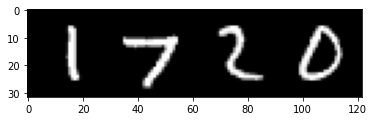

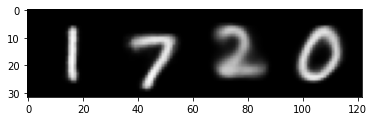

In [57]:

def imshow(img):
    npimg = img.detach().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

iterator = iter(testloader)
images, _ = iterator.next()
images = images.to(device)

imp = images.view(-1, 28*28)
rec, _, _ = model_3(imp)
#print(rec)
rec.detach()
rec = rec.reshape(rec.shape[0], 1, 28, 28)
print(images.shape)

# show image
imshow(torchvision.utils.make_grid(images).cpu())
imshow(torchvision.utils.make_grid(rec).cpu())


In [56]:
# variational model

In [99]:
print(1)